In [1]:
import fsspec

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data_path = Path("../data")

# What's the minimum amount of data to achieve r2 > 0.7

## What doest the sequence diversity look like?

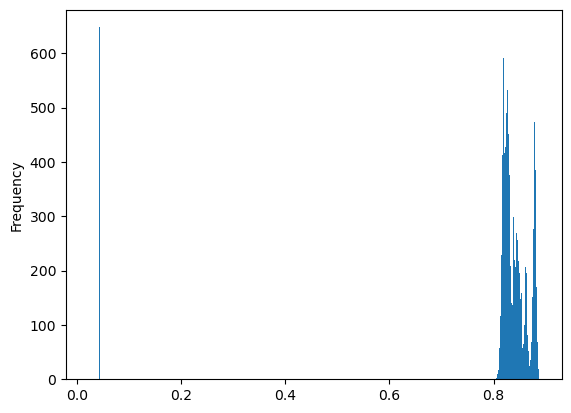

In [2]:
diversity = pd.read_csv(
    data_path / "stability_diversity_full.csv", index_col=0
).sort_values("diversity")
diversity.diversity.plot.hist(bins=500)
plt.show()

## Experiments

In [3]:
from protera_stability import ProteinMLP
from protera_stability import AttrDict, LitProteins, ProteinStabilityDataset, SubsetDiversitySampler
from protera_stability import PrintCallback

In [4]:
from IPython.display import clear_output, display

In [5]:
display?

In [6]:
import sys

In [22]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor,
)

import torch

from pytorch_lightning import loggers as pl_loggers
from typing import List
import shutil


def setup_conf(
    random_percent: float,
    cutoff: float,
    bs: int,
    sampling_dict: dict,
    max_epochs: int,
    train_percent: float = 0.85,
):
    dataset_size = 10281

    conf = AttrDict()
    conf.update(
        {
            "experiment": {"cutoff": cutoff, "random_percent": random_percent},
            "model_name": "ProteinMLP",
            "data": {
                "batch_size": bs,
                "random_split": [
                    int(dataset_size * train_percent),
                    dataset_size - int(dataset_size * train_percent),
                ],
                "sampling": sampling_dict,
            },
            "max_epochs": max_epochs,
            "optimizer": {
                "object": torch.optim.AdamW,
                "name": torch.optim.AdamW.__name__,
                "params": {
                    "lr": 1e-3,
                    "weight_decay": 0.01,
                },
                "schedulers": [
                    #                     {
                    #                         "object": torch.optim.lr_scheduler.ReduceLROnPlateau,
                    #                         "name": torch.optim.lr_scheduler.ReduceLROnPlateau.__name__,
                    #                         "params": {
                    #                             "patience": 2,
                    #                         },
                    #                     },
                    #                     {
                    #                         "object": torch.optim.lr_scheduler.CyclicLR,
                    #                         "name": torch.optim.lr_scheduler.CyclicLR.__name__,
                    #                         "params": {
                    #                             "base_lr": 1e-3,
                    #                             "max_lr": 1e-4,
                    #                             "cycle_momentum": False,
                    #                             "step_size_up": 500,
                    #                         },
                    #                     },
                    {
                        "object": torch.optim.lr_scheduler.CosineAnnealingLR,
                        "name": torch.optim.lr_scheduler.CosineAnnealingLR.__name__,
                        "params": {
                            "T_max": 70,
                        },
                    },
                ],
            },
        }
    )
    return conf


def setup_data(
    conf: AttrDict,
    sampling: str,
    diversity_cutoff: float,
    max_div_percent: float,
    random_percent: float,
    random_split: List[int],
):
    # update conf
    conf.data["random_split"] = random_split

    conf.data["sampling_name"] = sampling
    conf.data[f"sampling_diversity"] = dict()
    conf.data[f"sampling_diversity"]["diversity_cutoff"] = diversity_cutoff
    conf.data[f"sampling_diversity"]["diversity_path"] = (
        data_path / "stability_diversity_full.csv"
    )
    conf.data[f"sampling_random"] = dict()
    conf.data[f"sampling_random"]["random_percent"] = random_percent

    dataset = ProteinStabilityDataset(data_path / "stability.h5", ret_dict=False)
    train_set, val_set = torch.utils.data.random_split(
        dataset,
        [
            int(len(dataset) * conf.data["random_split"]),
            len(dataset) - int(len(dataset) * conf.data["random_split"]),
        ],
    )
    val_set, test_set = torch.utils.data.random_split(
        val_set,
        [
            int(len(val_set) * 0.5),
            len(val_set) - int(len(val_set) * 0.5),
        ],
    )

    conf.data[f"sampling_diversity"]["max_size"] = max_div_percent * len(train_set)

    if "diversity" == conf.data[f"sampling_name"]:
        sampler = SubsetDiversitySampler(
            set_indices=train_set.indices, **conf.data["sampling_diversity"]
        )
        print(f"=== USING SubsetDiversitySampler ===")
        print(f"=== USING {len(sampler)} out of {len(train_set)} samples ===")
        print(f"=== SIZE WAS DETERMINED BY {sampler.stopped_by} ===")

    elif "random" == conf.data[f"sampling_name"]:
        random_percent = conf.data["sampling_random"]["random_percent"]
        sampler = torch.utils.data.SubsetRandomSampler(
            range(int(len(train_set) * random_percent))
        )
        print(f"=== USING SubsetRandomSampler ===")
        print(f"=== USING {len(sampler)} out of {len(train_set)} samples ===")
        print(f"=== SIZE WAS DETERMINED BY RANDOM PERCENT OF {random_percent} ===")

    else:
        wrong_sampling = conf.data["sampling_name"]
        raise ValueError(f"Sampling Method {wrong_sampling} is not valid.")

    dl_params = {"num_workers": 12, "pin_memory": True}

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=conf.data["batch_size"], sampler=sampler, **dl_params
    )
    valid_loader = torch.utils.data.DataLoader(
        val_set, batch_size=conf.data["batch_size"] * 2, **dl_params
    )
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=conf.data["batch_size"] * 2, **dl_params
    )

    return {
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "test_loader": test_loader,
    }, conf


def create_cbs(ckpt_dir):
    ckpt_cb = ModelCheckpoint(ckpt_dir)
    stop_valid = EarlyStopping(
        monitor="valid_loss", patience=20, check_on_train_epoch_end=False
    )
    stop_r2_reached = EarlyStopping(
        monitor="valid_r2",
        patience=1,
        check_on_train_epoch_end=False,
        stopping_threshold=0.72,
        mode="max",
    )
    monitor_lr = LearningRateMonitor(logging_interval="epoch")

    return [ckpt_cb, stop_valid, stop_r2_reached, monitor_lr]


def setup_trainer(conf, ckpt_dir):
    model = ProteinMLP()
    net = LitProteins(model, conf)

    log_dir = Path(f"../logs/{ckpt_dir}")
    ckpt_dir = log_dir / "models"

    if log_dir.exists():
        shutil.rmtree(log_dir)
        log_dir.mkdir()
        ckpt_dir.mkdir()

    cbs = create_cbs(ckpt_dir)

    trainer = pl.Trainer(
        logger=pl_loggers.TensorBoardLogger(log_dir),
        gpus=1,
        max_epochs=conf.max_epochs,
        log_every_n_steps=1,
        callbacks=cbs,
        amp_backend="apex",
        amp_level="01",
        benchmark=True,
    )

    return {"model": net, "trainer": trainer}, conf


def setup(
    data_path,
    epochs=int(1e4),
    bs=256,
    sampling="diversity",
    diversity_cutoff=0.82,
    max_div_percent=0.9,
    random_percent=0.5,
    ckpt_dir="",
):

    sampling_dict = {}
    conf = setup_conf(
        random_percent=random_percent,
        cutoff=diversity_cutoff,
        bs=bs,
        sampling_dict=sampling_dict,
        max_epochs=epochs,
    )
    data_dict, conf = setup_data(
        conf,
        sampling=sampling,
        diversity_cutoff=diversity_cutoff,
        max_div_percent=max_div_percent,
        random_percent=random_percent,
        random_split=0.8,
    )
    trainer_dict, conf = setup_trainer(conf, ckpt_dir=ckpt_dir)
    experiment_conf = {
        "model": trainer_dict["model"],
        "trainer": trainer_dict["trainer"],
        "train_loader": data_dict["train_loader"],
        "valid_loader": data_dict["valid_loader"],
        "test_loader": data_dict["test_loader"],
    }
    return experiment_conf

In [23]:
# an experiment
exp = setup(data_path, epochs=100, sampling="random", random_percent=0.1, ckpt_dir="base")
exp["trainer"].fit(exp["model"], exp["train_loader"], exp["valid_loader"])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING SubsetRandomSampler ===
=== USING 822 out of 8224 samples ===
=== SIZE WAS DETERMINED BY RANDOM PERCENT OF 0.1 ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [24]:
exp["trainer"].test(exp["model"], exp["test_loader"])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.26533111929893494,
 'test_r2': 0.5924072265625,
 'test_r2_step': 0.651240348815918}
--------------------------------------------------------------------------------


[{'test_r2_step': 0.651240348815918,
  'test_r2': 0.5924072265625,
  'test_loss': 0.26533111929893494}]

In [25]:
from tqdm import tqdm

def run_experiment(data_path, epochs, max_randoms, cutoffs):

    print("=== RUNNING RANDOM SAMPLING ===")
    for random_percent in tqdm(max_randoms):
        conf = setup_conf(
            random_percent=random_percent,
            cutoff=None,
            bs=256,
            max_epochs=epochs,
            sampling_dict={},
        )
        exp = setup(
            data_path,
            epochs=epochs,
            sampling="random",
            random_percent=random_percent,
            ckpt_dir=f"stability_random_{random_percent}",
        )
        exp["trainer"].fit(exp["model"], exp["train_loader"], exp["valid_loader"])
        exp["trainer"].test(exp["model"], exp["test_loader"])

    print("=== RUNNING DIVERSITY SAMPLING ===")
    for cut in tqdm(cutoffs):
        conf = setup_conf(
            random_percent=random_percent,
            cutoff=cut,
            bs=256,
            max_epochs=epochs,
            sampling_dict={},
        )
        exp = setup(
            data_path,
            epochs=epochs,
            sampling="diversity",
            diversity_cutoff=cut,
            max_div_percent=max_randoms[0],
            ckpt_dir=f"stability_cut_{cut}",
        )
        exp["trainer"].fit(exp["model"], exp["train_loader"], exp["valid_loader"])
        exp["trainer"].test(exp["model"], exp["test_loader"])

In [26]:
random_percents = [0.9, 0.7, 0.5, 0.4, 0.3, 0.2]
cutoffs = [0.75, 0.8, 0.83, 0.84, 0.86]

run_experiment(
    data_path=data_path, epochs=150, max_randoms=random_percents, cutoffs=cutoffs
)

=== RUNNING RANDOM SAMPLING ===




  0%|          | 0/6 [00:00<?, ?it/s]GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


=== USING SubsetRandomSampler ===
=== USING 7401 out of 8224 samples ===
=== SIZE WAS DETERMINED BY RANDOM PERCENT OF 0.9 ===



  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]



 17%|█▋        | 1/6 [00:35<02:58, 35.65s/it]GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.14598867297172546,
 'test_r2': 0.7211324572563171,
 'test_r2_step': 0.7851956486701965}
--------------------------------------------------------------------------------
=== USING SubsetRandomSampler ===
=== USING 5756 out of 8224 samples ===
=== SIZE WAS DETERMINED BY RANDOM PERCENT OF 0.7 ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]



 33%|███▎      | 2/6 [01:21<02:46, 41.51s/it]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.16888099908828735,
 'test_r2': 0.7224724292755127,
 'test_r2_step': 0.7833094596862793}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING SubsetRandomSampler ===
=== USING 4112 out of 8224 samples ===
=== SIZE WAS DETERMINED BY RANDOM PERCENT OF 0.5 ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]



 50%|█████     | 3/6 [02:18<02:25, 48.50s/it]GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.16788864135742188,
 'test_r2': 0.7128893136978149,
 'test_r2_step': 0.7959465980529785}
--------------------------------------------------------------------------------
=== USING SubsetRandomSampler ===
=== USING 3289 out of 8224 samples ===
=== SIZE WAS DETERMINED BY RANDOM PERCENT OF 0.4 ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]



 67%|██████▋   | 4/6 [03:23<01:50, 55.10s/it]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.17130863666534424,
 'test_r2': 0.7217830419540405,
 'test_r2_step': 0.7937673330307007}
--------------------------------------------------------------------------------
=== USING SubsetRandomSampler ===
=== USING 2467 out of 8224 samples ===
=== SIZE WAS DETERMINED BY RANDOM PERCENT OF 0.3 ===


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]



 83%|████████▎ | 5/6 [04:25<00:57, 57.65s/it]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.2173829972743988,
 'test_r2': 0.7219308614730835,
 'test_r2_step': 0.7908173203468323}
--------------------------------------------------------------------------------
=== USING SubsetRandomSampler ===
=== USING 1644 out of 8224 samples ===
=== SIZE WAS DETERMINED BY RANDOM PERCENT OF 0.2 ===


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]



100%|██████████| 6/6 [04:55<00:00, 49.25s/it]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.2647587060928345,
 'test_r2': 0.6243448853492737,
 'test_r2_step': 0.7196248769760132}
--------------------------------------------------------------------------------
=== RUNNING DIVERSITY SAMPLING ===




  0%|          | 0/5 [00:00<?, ?it/s]GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING SubsetDiversitySampler ===
=== USING 7402 out of 8224 samples ===
=== SIZE WAS DETERMINED BY MAX SIZE REACHED ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]



 20%|██        | 1/5 [00:51<03:26, 51.69s/it]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.5286311507225037,
 'test_r2': 0.7199774980545044,
 'test_r2_step': 0.6801271438598633}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING SubsetDiversitySampler ===
=== USING 7402 out of 8224 samples ===
=== SIZE WAS DETERMINED BY MAX SIZE REACHED ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]



 40%|████      | 2/5 [01:39<02:29, 49.68s/it]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3061550259590149,
 'test_r2': 0.7216023802757263,
 'test_r2_step': 0.7071459293365479}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING SubsetDiversitySampler ===
=== USING 4350 out of 8224 samples ===
=== SIZE WAS DETERMINED BY CUTOFF ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]



 60%|██████    | 3/5 [03:01<02:08, 64.09s/it]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.48702797293663025,
 'test_r2': 0.7209008932113647,
 'test_r2_step': 0.6097767949104309}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING SubsetDiversitySampler ===
=== USING 3390 out of 8224 samples ===
=== SIZE WAS DETERMINED BY CUTOFF ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]



 80%|████████  | 4/5 [03:43<00:55, 55.46s/it]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.8080472946166992,
 'test_r2': 0.6125380992889404,
 'test_r2_step': 0.3881194591522217}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING SubsetDiversitySampler ===
=== USING 1824 out of 8224 samples ===
=== SIZE WAS DETERMINED BY CUTOFF ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]



100%|██████████| 5/5 [04:18<00:00, 51.66s/it]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.8727777600288391,
 'test_r2': 0.33991706371307373,
 'test_r2_step': 0.06813069432973862}
--------------------------------------------------------------------------------
